In [ ]:
Oracle AI Data Platform v1.0

Copyright © 2025, Oracle and/or its affiliates.

Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl/

# Spark Delta SQL Examples
 **Learn basic Delta features in IDL**

 See https://docs.delta.io/latest/index.html for detailed documentation.
 
 This notebook demonstrates different ways to read and write data from Delta tables in AI Data Platform. It covers:
 
 1. **Setup catalog and schemas**
 2. **Create Delta Table**
 3. **Delta Table operations**
    - Insert data
    - Update data
    - Query Data
 4. **Schema exploration**
    - Listing schemas and tables
    - Describing delta table history data
 5. **Merge**
    - Merge data
 6. **Time travel**
    - Query by version
    - Query by timestamp
 7. **Advanced Delta**
 

# **1. Setup catalog and schemas**

## Show Catalogs

In [1]:
spark.sql("show catalogs").show()

+------------+--------+-----------+--------------------+-------------+
|catalog_name| type|source_type| created_by| created_at|
+------------+--------+-----------+--------------------+-------------+
| hive|INTERNAL| N.A|ocid1.user.oc1..a...|1742660232068|
| discovered|INTERNAL| N.A|ocid1.user.oc1..a...|1742752860364|
| lake|INTERNAL| N.A|ocid1.user.oc1..a...|1742755977633|
|lake_example|INTERNAL| N.A|ocid1.user.oc1..a...|1742668284598|
+------------+--------+-----------+--------------------+-------------+

## Create Managed Catalog

In [1]:
# Create managed catalog
spark.sql("create catalog if not exists lake")


In [1]:
# Describe Catalog
spark.sql("describe catalog lake").show()

+------------------+--------------------+
| attribute| attribute_value|
+------------------+--------------------+
| name| lake|
| createdOn| 1742755977633|
| updatedOn| 1742755977275|
|connection_details| {}|
| catalog_details|{"createdOn":"174...|
| createdBy|ocid1.user.oc1..a...|
| type| INTERNAL|
| updatedBy|ocid1.user.oc1..a...|
+------------------+--------------------+

## Create Schema in Managed Catalog

In [1]:
# Create Schema
spark.sql("create schema if not exists lake.bronze")

In [1]:
# Describe Schema
spark.sql("describe schema lake.bronze").show()

+--------------+----------+
| info_name|info_value|
+--------------+----------+
| Catalog Name| lake|
|Namespace Name| bronze|
+--------------+----------+

# **2. Create Delta Table**

## Create Target Delta Table

In [1]:
from pyspark.sql import SparkSession
# Sample patient data
data = [
    ("2025-03-24T08:00:00Z", "P001", 72, "120/80", 98, 36.8, "302A", "stable"),
    ("2025-03-24T08:05:00Z", "P001", 75, "118/78", 97, 36.9, "302A", "stable"),
    ("2025-03-24T08:10:00Z", "P002", 90, "140/90", 92, 38.2, "215B", "critical"),
    ("2025-03-24T08:15:00Z", "P002", 95, "145/95", 90, 38.5, "215B", "critical")
]

columns = ["timestamp", "patient_id", "heart_rate_bpm", "blood_pressure", "oxygen_saturation", "temperature_C", "room_number", "status"]

df = spark.createDataFrame(data, columns)

# Save as Delta Table
df.write.format("delta").mode("overwrite").saveAsTable("lake.bronze.patient")


# **3. Delta Table Operations**

# Update Data in Delta Table

In [1]:
spark.sql("update lake.bronze.patient set room_number='302X' where patient_id='P001'")

## Query Data

In [1]:
# Query managed table
spark.sql("select * from lake.bronze.patient").show()

+--------------------+----------+--------------+--------------+-----------------+-------------+-----------+--------+
| timestamp|patient_id|heart_rate_bpm|blood_pressure|oxygen_saturation|temperature_C|room_number| status|
+--------------------+----------+--------------+--------------+-----------------+-------------+-----------+--------+
|2025-03-24T08:10:00Z| P002| 90| 140/90| 92| 38.2| 215B|critical|
|2025-03-24T08:15:00Z| P002| 95| 145/95| 90| 38.5| 215B|critical|
|2025-03-24T08:00:00Z| P001| 72| 120/80| 98| 36.8| 302X| stable|
|2025-03-24T08:05:00Z| P001| 75| 118/78| 97| 36.9| 302X| stable|
+--------------------+----------+--------------+--------------+-----------------+-------------+-----------+--------+

# **4. Schema Exploration**

## Show Schemas, Tables, Describe Tables

In [1]:
spark.sql("show schemas in lake").show()

+---------+
|namespace|
+---------+
| default|
| bronze|
+---------+

In [1]:
spark.sql("show tables in lake.bronze").show()

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
| bronze| patient| false|
+---------+---------+-----------+

In [1]:
# List tables using a pattern eg. tables beginning with e
spark.sql("show tables in lake.bronze like 'p.*'").show()

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
| bronze| patient| false|
+---------+---------+-----------+

In [1]:
# Describe managed table, see type is MANAGED and provider is DELTA
spark.sql("describe table extended lake.bronze.patient").show()

+--------------------+--------------------+-------+
| col_name| data_type|comment|
+--------------------+--------------------+-------+
| timestamp| string| NULL|
| patient_id| string| NULL|
| heart_rate_bpm| bigint| NULL|
| blood_pressure| string| NULL|
| oxygen_saturation| bigint| NULL|
| temperature_C| double| NULL|
| room_number| string| NULL|
| status| string| NULL|
| | | |
|# Detailed Table ...| | |
| Name| lake.bronze.patient| |
| Type| MANAGED| |
| Location|oci://nnn... | |
| Provider| delta| |
| Owner|ocid1.user.oc1..a...| |
| Table Properties|[delta.minReaderV...| |
+--------------------+--------------------+-------+

In [1]:
# Describe history of Delta table
spark.sql("describe history lake.bronze.patient").show()

+-------+-------------------+------+--------+------------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|version| timestamp|userId|userName| operation| operationParameters| job|notebook|clusterId|readVersion|isolationLevel|isBlindAppend| operationMetrics|userMetadata| engineInfo|
+-------+-------------------+------+--------+------------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
| 2|2025-03-24 17:05:41| NULL| NULL| UPDATE|{predicate -> ["(...|NULL| NULL| NULL| 1| Serializable| false|{numRemovedFiles ...| NULL|Apache-Spark/3.5....|
| 1|2025-03-24 17:05:31| NULL| NULL| WRITE|{mode -> Append, ...|NULL| NULL| NULL| 0| Serializable| true|{numFiles -> 2, n...| NULL|Apache-Spark/3.5....|
| 0|2025-03-24 17:05:22| NULL| NULL|CREATE TABLE|{partitionBy -> [...|NULL| NULL| NULL| NULL| Serializable| true| {}| NULL|Apache-Spark/3.5....|
+-------+-------------------+------+--------+------------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+

# List all tables in all schemas in a catalog

In [1]:
catalog_name="lake"
databases = [
    catalog_name+"."+db.namespace 
    for db in spark.sql('show schemas in '+catalog_name).collect()
]
tables = [
    catalog_name+"."+f"{row['namespace']}.{row['tableName']}" #<catalog>.<schema>.<table> format
    for db_rows in [
        spark.sql(f'show tables in {db}').collect() for db in databases
    ] 
    for row in db_rows
]
print(tables)

["lake.bronze.patient"]

# **5. Merge Operation**

## Merge into Delta Table

In [1]:
# Load Delta Table
deltaTable = spark.sql("select * from lake.bronze.patient")

# New data update
new_data = spark.createDataFrame([
    ("2025-03-24T08:20:00Z", "P002", 100, "150/100", 88, 39.0, "ICU", "critical")  # Moved to ICU
], columns)

new_data.createOrReplaceTempView("src")

#
spark.sql("merge into lake.bronze.patient as dest \
using src as src \
on src.patient_id = dest.patient_id \
when matched then update set room_number = src.room_number, status=src.status \
when not matched then insert *")


In [1]:
spark.read.table("lake.bronze.patient").show()

+--------------------+----------+--------------+--------------+-----------------+-------------+-----------+--------+
| timestamp|patient_id|heart_rate_bpm|blood_pressure|oxygen_saturation|temperature_C|room_number| status|
+--------------------+----------+--------------+--------------+-----------------+-------------+-----------+--------+
|2025-03-24T08:10:00Z| P002| 90| 140/90| 92| 38.2| ICU|critical|
|2025-03-24T08:15:00Z| P002| 95| 145/95| 90| 38.5| ICU|critical|
|2025-03-24T08:00:00Z| P001| 72| 120/80| 98| 36.8| 302X| stable|
|2025-03-24T08:05:00Z| P001| 75| 118/78| 97| 36.9| 302X| stable|
+--------------------+----------+--------------+--------------+-----------------+-------------+-----------+--------+

# **6. Time Travel**

# Querying Delta Tables - Time Travel

In [1]:
# Querying as of version - try versions to see the data at specific versions in time
spark.sql("select * from lake.bronze.patient VERSION AS OF 1").show()

+--------------------+----------+--------------+--------------+-----------------+-------------+-----------+--------+
| timestamp|patient_id|heart_rate_bpm|blood_pressure|oxygen_saturation|temperature_C|room_number| status|
+--------------------+----------+--------------+--------------+-----------------+-------------+-----------+--------+
|2025-03-24T08:10:00Z| P002| 90| 140/90| 92| 38.2| 215B|critical|
|2025-03-24T08:15:00Z| P002| 95| 145/95| 90| 38.5| 215B|critical|
|2025-03-24T08:00:00Z| P001| 72| 120/80| 98| 36.8| 302A| stable|
|2025-03-24T08:05:00Z| P001| 75| 118/78| 97| 36.9| 302A| stable|
+--------------------+----------+--------------+--------------+-----------------+-------------+-----------+--------+

In [1]:
# Query as of timestamp - change the date/make generic
spark.sql("select * from lake.bronze.patient TIMESTAMP AS OF '2025-03-24 17:05:45.000Z'").show()

+--------------------+----------+--------------+--------------+-----------------+-------------+-----------+--------+
| timestamp|patient_id|heart_rate_bpm|blood_pressure|oxygen_saturation|temperature_C|room_number| status|
+--------------------+----------+--------------+--------------+-----------------+-------------+-----------+--------+
|2025-03-24T08:10:00Z| P002| 90| 140/90| 92| 38.2| 215B|critical|
|2025-03-24T08:15:00Z| P002| 95| 145/95| 90| 38.5| 215B|critical|
|2025-03-24T08:00:00Z| P001| 72| 120/80| 98| 36.8| 302X| stable|
|2025-03-24T08:05:00Z| P001| 75| 118/78| 97| 36.9| 302X| stable|
+--------------------+----------+--------------+--------------+-----------------+-------------+-----------+--------+

# **7. Advanced Delta**

# Liquid Clustering 

https://docs.delta.io/latest/delta-clustering.html

Liquid clustering improves the existing partitioning and ZORDER techniques by simplifying data layout decisions in order to optimize query performance. Liquid clustering provides flexibility to redefine clustering columns without rewriting existing data, allowing data layout to evolve alongside analytic needs over time.


In [1]:
spark.sql("create table lake.bronze.clusteredtable (c1 int, c2 string) USING DELTA CLUSTER BY (c1)")

In [1]:
spark.sql("insert into lake.bronze.clusteredtable select 1 c1, 'hello world' c2")

# Vacuum - Remove files no longer referenced

https://docs.delta.io/latest/delta-utility.html#remove-files-no-longer-referenced-by-a-delta-table

In [1]:
spark.sql("vacuum lake.bronze.clusteredtable ")

# Restore from history

In [1]:
spark.sql("describe history lake.bronze.clusteredtable ").show()

+-------+-------------------+------+--------+------------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|version| timestamp|userId|userName| operation| operationParameters| job|notebook|clusterId|readVersion|isolationLevel|isBlindAppend| operationMetrics|userMetadata| engineInfo|
+-------+-------------------+------+--------+------------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
| 2|2025-03-24 15:31:52| NULL| NULL| WRITE|{mode -> Append, ...|NULL| NULL| NULL| 1| Serializable| true|{numFiles -> 1, n...| NULL|Apache-Spark/3.5....|
| 1|2025-03-24 15:31:37| NULL| NULL| WRITE|{mode -> Append, ...|NULL| NULL| NULL| 0| Serializable| true|{numFiles -> 1, n...| NULL|Apache-Spark/3.5....|
| 0|2025-03-24 15:30:30| NULL| NULL|CREATE TABLE|{partitionBy -> [...|NULL| NULL| NULL| NULL| Serializable| true| {}| NULL|Apache-Spark/3.5....|
+-------+-------------------+------+--------+------------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+

In [1]:
spark.sql("RESTORE TABLE lake.bronze.clusteredtable TO VERSION AS OF 1")

In [1]:
spark.sql("select * from lake.bronze.clusteredtable").show()

+---+-----+
| c1| c2|
+---+-----+
| 1|hello|
+---+-----+


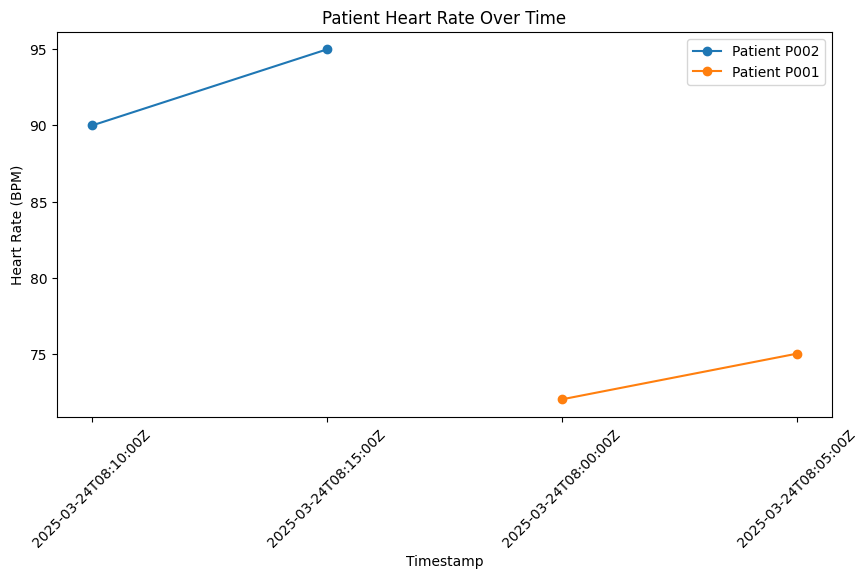

In [1]:
import matplotlib.pyplot as plt

# Convert Delta Table to Pandas
deltaTable = spark.sql("select * from lake.bronze.patient")
df_pandas = deltaTable.toPandas()

# Plot
plt.figure(figsize=(10,5))
for patient in df_pandas["patient_id"].unique():
    patient_data = df_pandas[df_pandas["patient_id"] == patient]
    plt.plot(patient_data["timestamp"], patient_data["heart_rate_bpm"], marker='o', label=f"Patient {patient}")

plt.xlabel("Timestamp")
plt.ylabel("Heart Rate (BPM)")
plt.title("Patient Heart Rate Over Time")
plt.legend()
plt.xticks(rotation=45)
plt